# Cell-DEVS visualizer for pandemic scenarios

This notebook parses the simulation output of a cellular pandemic scenario and plots SIRD curves. Let's first import all the required Python packages:

In [78]:
import os
import re
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## Data Processing
First, we need to parse the simulation outcome. We provide some functions to do so.

Before parsing the data, we need to specify the name with the simulation results, the name of the folder that will contain all the visualization data, the shape of the scenario, and the number of age segments in the scenario.
You might be interested on changing the last two fields to fit with your scenario:

In [79]:
log_filename = "output_messages.txt"  # Name of the simulation output file.
res_folder = "res"                    # Name of the folder that will contain the visualization outcome.

shape = (25,25)     # Make sure that it coincides with the shape of your scenario.
n_age_segments = 4  # Make sure that it coincides with the number of age segments in your scenario.

We now define a couple of functions for parsing the simulation outcome. You don't need to change anything here:

In [82]:
def cell_states_to_scenario_state(sim_time, curr_states): 
    # First, we infer the dimensions and number of age segments of the scenario
    x = len(curr_states)
    if x == 0:
        return
    y = len(curr_states[0])
    if y == 0:
        return
    n = len(curr_states[0][0]) // 5 - 1
    if n <= 0:
        return
    
    # Second, we compute the numbers for each age group
    pop_per_age = [0 for _ in range(n)]
    sus_per_age = [0 for _ in range(n)]
    inf_per_age = [0 for _ in range(n)]
    rec_per_age = [0 for _ in range(n)]
    dec_per_age = [0 for _ in range(n)]
    for i in range(x):
        for j in range(y):
            for k in range(n):
                pop_k_in_cell = curr_states[i][j][5 * k]
                pop_per_age[k] += pop_k_in_cell
                sus_per_age[k] += pop_k_in_cell * curr_states[i][j][5 * k + 1]
                inf_per_age[k] += pop_k_in_cell * curr_states[i][j][5 * k + 2]
                rec_per_age[k] += pop_k_in_cell * curr_states[i][j][5 * k + 3]
                dec_per_age[k] += pop_k_in_cell * curr_states[i][j][5 * k + 4]
    
    # Then we compute the total value
    total_pop = sum(pop_per_age)
    total_sus = sum(sus_per_age)
    total_inf = sum(inf_per_age)
    total_rec = sum(rec_per_age)
    total_dec = sum(dec_per_age)
    
    # Now, we normalize the ratios
    for k in range(n):
        pop_k = pop_per_age[k]
        sus_per_age[k] /= pop_k
        inf_per_age[k] /= pop_k
        rec_per_age[k] /= pop_k
        dec_per_age[k] /= pop_k
        k_ratio = sus_per_age[k] + inf_per_age[k] + rec_per_age[k] + dec_per_age[k]
    total_sus /= total_pop
    total_inf /= total_pop
    total_rec /= total_pop
    total_dec /= total_pop
    total_ratio = total_sus + total_inf + total_rec + total_dec
    
    # Finally, we fill the row in the correct order
    res = [int(sim_time)]
    for k in range(n):
        res.extend([pop_per_age[k], sus_per_age[k], inf_per_age[k], rec_per_age[k], dec_per_age[k]])
    res.extend([total_pop, total_sus, total_inf, total_rec, total_dec])
    return res


def read_data(filename, scenario_shape, age_segments):
    patt_out_line = "\{\((?P<x>\w+),(?P<y>\w+)\).*<(?P<state>[\w,. -]+)>"
    
    cells_data = []
    scenario_data = []
    
    curr_data = []
    curr_time = None
    curr_states = [[[0 for _ in range(5 * (age_segments + 1))] for _ in range(scenario_shape[1])] for _ in range(scenario_shape[0])]
    with open(filename, "r") as log_file:
        for line in log_file:
            line = line.strip()
            if line.isnumeric() and line != curr_time:
                past_time = curr_time
                curr_time = line
                if past_time is not None:
                    scenario_data.append(cell_states_to_scenario_state(curr_time, curr_states))
                continue

            match = re.search(patt_out_line, line)
            if not match:
                continue

            x = int(match.group("x"))
            y = int(match.group("y"))

            state = list(map(float, match.group("state").split(",")))
            curr_states[x][y] = state
            if curr_time is not None:
                cells_data.append([x, y, int(curr_time), *state])
        scenario_data.append(cell_states_to_scenario_state(curr_time, curr_states))
        
    return cells_data, scenario_data

Let's parse the simulation outcome. The processed data will be stored in two CSV files inside the results folder:

In [83]:
cells_data, scenario_data = read_data(log_filename, shape, n_age_segments)

cell_columns = ["x", "y", "time"]
cell_columns.extend(["{}_{}".format(label, i) for i in range(n_age_segments) for label in ["population", "susceptible", "infected", "recovered", "deceased"]])
cell_columns.extend(["population", "susceptible", "infected", "recovered", "deceased"])

scenario_columns = cell_columns[2:]

cells_df = pd.DataFrame(cells_data, columns=cell_columns , index=None)
cells_df.to_csv(os.path.join(res_folder, "cells_state.csv"))

scenario_df = pd.DataFrame(scenario_data, columns=scenario_columns)
scenario_df = scenario_df.set_index("time")
scenario_df.to_csv(os.path.join(res_folder, "scenario_state.csv"))

## Data Visualization

Once data has been processed, we are ready to visualize it. Before plotting anything, we'll define different variables for modifying the aspect of the plots (e.g., curves color and font-related parameters):

In [84]:
COLOR_SUSCEPTIBLE = "#3498db"  # RGB color (in hexadecimal) for susceptible curves. By default, it is blue.
COLOR_INFECTED = "#e74c3c"     # RGB color (in hexadecimal) for infected curves. By default, it is red.
COLOR_RECOVERED = "#2ecc71"    # RGB color (in hexadecimal) for recovered curves. By default, it is green.
COLOR_DECEASED = "#8ba2ad"     # RGB color (in hexadecimal) for deceased curves. By default, it is grey.

font = {'family' : 'Times New Roman',  # Font used in the graphs
        'weight' : 'normal',           # Font weight in the graphs
        'size'   : 20}                 # Font size in the graphs
matplotlib.rc('font', **font)

### Stack plot of SIRD ratios

Stack plots are useful to compare the ratio of the different pandemic states. You can define the following parameters:
- `target_cell`: if set to `None`, the plot will show the average ratio of all the cells of the scenario. On the other hand, if you set it to a tuple containing the coordinates of a cell inside the scenario (e.g., `(12,12)`), the plot will show data of only the selected cell.
- `age_segment`: if set to `None`, the plot will show the average ratio of all the age segments of the scenario. On the other hand, if you set it to an integer number corresponding to a valid age segment (e.g., `0`), the plot will show data of only the selected age segment.

In [85]:
target_cell = (12,12)  # You can modify this value to select one cell. If you set it to None, then all the cells are selected
age_segment = 3        # You can modify this value to represent the age segment you like the most. If you set it to None, then it plots values for the entire population

# The following lines assert that the target cell and age segment have valid values
assert target_cell is None or 0 <= target_cell[0] < shape[0] and 0 <= target_cell[1] < shape[1]
assert age_segment is None or 0 <= age_segment < n_age_segments

The next cell will plot the results. Additionally, a PDF file with the graph will be stored in the results folder.

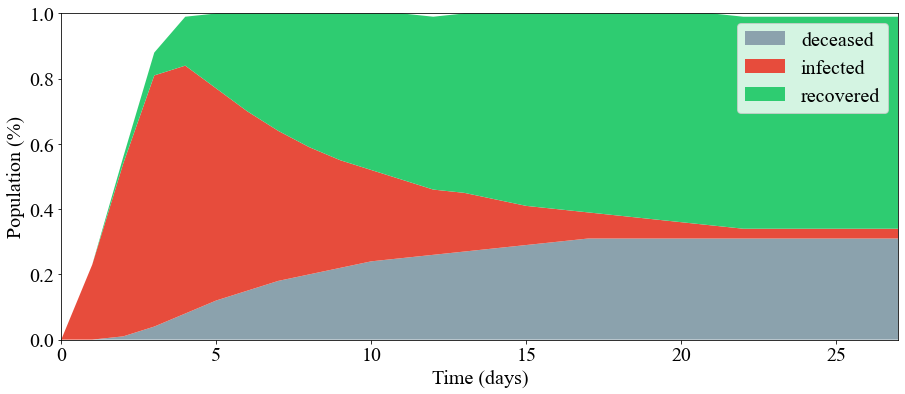

In [86]:
col_names = ["deceased", "infected", "recovered"]
colors=[COLOR_DECEASED, COLOR_INFECTED, COLOR_RECOVERED]

figname = os.path.join(res_folder, "stack_plot")
if target_cell is None:
    df = scenario_df
else:
    df = cells_df.loc[(cells_df["x"] == target_cell[0]) & (cells_df["y"] == target_cell[1])]
    df = df.set_index("time")
    figname += "_cell_{}_{}".format(target_cell[0], target_cell[1])

if age_segment is None:
    cols = col_names
else:
    cols = [col + "_" + str(age_segment) for col in col_names]
    figname += "_age_{}".format(age_segment)
figname += ".pdf"

x = list(df.index)
y = np.vstack([df[col] for col in cols])

fig, ax = plt.subplots(figsize=(15,6))
ax.stackplot(x, y, labels=col_names, colors=colors)
plt.legend(loc='upper right')
plt.margins(0,0)
plt.xlabel("Time (days)")
plt.ylabel("Population (%)")
plt.ylim((0,1))
plt.savefig(figname)

### Lines plot of SIRD ratios

Lines plots are another popular method for displaying SIRDS models results. This plot has the same configuration parameters. For the sake of convenience, the next cell enables you to re-define these configuration parameters.

In [87]:
target_cell = None  # You can modify this value to select one cell. If you set it to None, then all the cells are selected
age_segment = 3        # You can modify this value to represent the age segment you like the most. If you set it to None, then it plots values for the entire population

# The following lines assert that the target cell and age segment have valid values
assert target_cell is None or 0 <= target_cell[0] < shape[0] and 0 <= target_cell[1] < shape[1]
assert age_segment is None or 0 <= age_segment < n_age_segments

The next cell will plot the results. Additionally, a PDF file with the graph will be stored in the results folder.

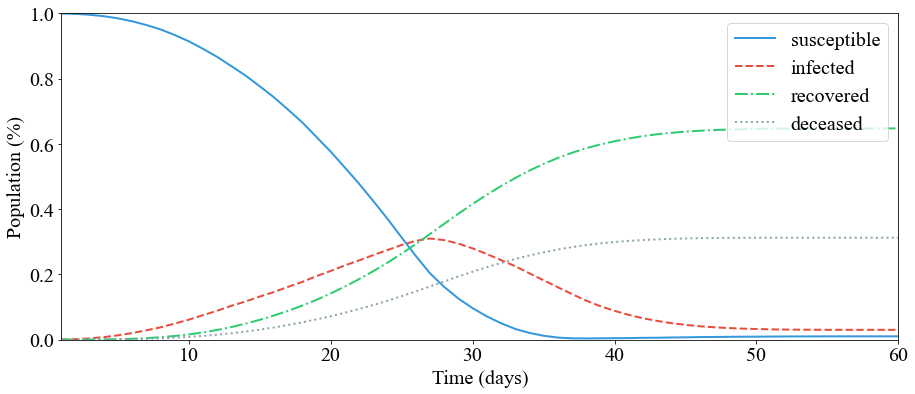

In [88]:
fig, ax = plt.subplots(figsize=(15,6))
linewidth = 2

figname = os.path.join(res_folder, "lines_plot")
if target_cell is None:
    df = scenario_df
else:
    df = cells_df.loc[(cells_df["x"] == target_cell[0]) & (cells_df["y"] == target_cell[1])]
    df = df.set_index("time")
    figname += "_cell_{}_{}".format(target_cell[0], target_cell[1])

x = list(df.index)

sus_col = "susceptible"
inf_col = "infected"
rec_col = "recovered"
dec_col = "deceased"
if age_segment is not None:
    suffix = "_{}".format(age_segment)
    sus_col += suffix
    inf_col += suffix
    rec_col += suffix
    dec_col += suffix
    figname += "_age_{}".format(age_segment)
figname += ".pdf"

ax.plot(x, df[sus_col], label="susceptible", color=COLOR_SUSCEPTIBLE, linewidth=linewidth)
ax.plot(x, df[inf_col], label="infected", color=COLOR_INFECTED, linewidth=linewidth, linestyle="--")
ax.plot(x, df[rec_col], label="recovered", color=COLOR_RECOVERED, linewidth=linewidth, linestyle="-.")
ax.plot(x, df[dec_col], label="deceased", color=COLOR_DECEASED, linewidth=linewidth, linestyle=":")
plt.legend(loc='upper right')
plt.margins(0,0)
plt.xlabel("Time (days)")
plt.ylabel("Population (%)")
plt.savefig(figname)

In most of the cases, the infected and deceased ratios will be significantly less than the susceptible and recovered ratios. Thus, plotting all the curves with the same Y axis may hinder the comparison between scenarios.
Fortunately, we also provide a script for plotting the curves in different graphs.

First, let's re-define the visualization configuration parameters:

In [89]:
target_cell = None  # You can modify this value to select one cell. If you set it to None, then all the cells are selected
age_segment = 3        # You can modify this value to represent the age segment you like the most. If you set it to None, then it plots values for the entire population

# The following lines assert that the target cell and age segment have valid values
assert target_cell is None or 0 <= target_cell[0] < shape[0] and 0 <= target_cell[1] < shape[1]
assert age_segment is None or 0 <= age_segment < n_age_segments

The next cell will plot the results. Additionally, a PDF file with the graph will be stored in the results folder.

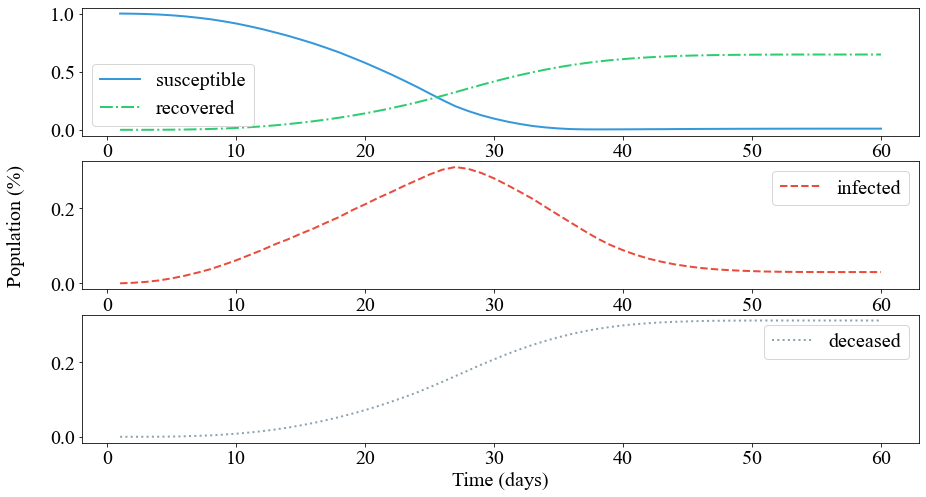

In [90]:
fig, axs = plt.subplots(3, figsize=(15,8))
linewidth = 2

figname = os.path.join(res_folder, "sep_lines_plot")
if target_cell is None:
    df = scenario_df
else:
    df = cells_df.loc[(cells_df["x"] == target_cell[0]) & (cells_df["y"] == target_cell[1])]
    df = df.set_index("time")
    figname += "_cell_{}_{}".format(target_cell[0], target_cell[1])

x = list(df.index)

sus_col = "susceptible"
inf_col = "infected"
rec_col = "recovered"
dec_col = "deceased"
if age_segment is not None:
    suffix = "_{}".format(age_segment)
    sus_col += suffix
    inf_col += suffix
    rec_col += suffix
    dec_col += suffix
    figname += "_age_{}".format(age_segment)
figname += ".pdf"

axs[0].plot(x, df[sus_col], label="susceptible", color=COLOR_SUSCEPTIBLE, linewidth=linewidth)
axs[0].plot(x, df[rec_col], label="recovered", color=COLOR_RECOVERED, linewidth=linewidth, linestyle="-.")
axs[0].legend()

axs[1].plot(x, df[inf_col], label="infected", color=COLOR_INFECTED, linewidth=linewidth, linestyle="--")
axs[1].set(ylabel="Population (%)\n")
axs[1].legend()

axs[2].plot(x, df[dec_col], label="deceased", color=COLOR_DECEASED, linewidth=linewidth, linestyle=":")
axs[2].set(xlabel='Time (days)')
axs[2].legend()
plt.savefig(figname)

### Comparing the SIRD curves of two cells

So far, we plotted the SIRD curve of a single cell and a single age segments. However, it may be useful comparing the SIRD curves of two cells/age segments to compare the effect of the pandemic on each of them. The following cells of the notebook display comparative graphs. First, let's define which colors we want in the graphs:

In [103]:
COLOR_SUSCEPTIBLE_1 = "#3498db"  # RGB color (in hexadecimal) for susceptible curves of first cell. By default, it is blue.
COLOR_INFECTED_1 = "#e74c3c"     # RGB color (in hexadecimal) for infected curves of first cell. By default, it is red.
COLOR_RECOVERED_1 = "#2ecc71"    # RGB color (in hexadecimal) for recovered curves of first cell. By default, it is green.
COLOR_DECEASED_1 = "#8ba2ad"     # RGB color (in hexadecimal) for deceased curves of first cell. By default, it is grey.

COLOR_SUSCEPTIBLE_2 = "#cb6724"  # RGB color (in hexadecimal) for susceptible curves of second cell. By default, it is orange.
COLOR_INFECTED_2 = "#18b3c3"     # RGB color (in hexadecimal) for infected curves of second cell. By default, it is blue.
COLOR_RECOVERED_2 = "#d1338e"    # RGB color (in hexadecimal) for recovered curves of second cell. By default, it is pink.
COLOR_DECEASED_2 = "#745d52"     # RGB color (in hexadecimal) for deceased curves of second cell. By default, it is brown.

Now, we can define the target cells and/or age segments (note that now we have to define two target cells and two age segments):

In [101]:
target_cell_1 = (0,0)  # You can modify this value to select one cell. If you set it to None, then all the cells are selected
age_segment_1 = 0  # You can modify this value to represent the age segment you like the most. If you set it to None, then it plots values for the entire population

target_cell_2 = (12,12)  # You can modify this value to select one cell. If you set it to None, then all the cells are selected
age_segment_2 = 2  # You can modify this value to represent the age segment you like the most. If you set it to None, then it plots values for the entire population


# The following lines assert that the target cells and age segments have valid values
assert target_cell_1 is None or 0 <= target_cell_1[0] < shape[0] and 0 <= target_cell_1[1] < shape[1]
assert age_segment_1 is None or 0 <= age_segment_1 < n_age_segments

assert target_cell_2 is None or 0 <= target_cell_2[0] < shape[0] and 0 <= target_cell_2[1] < shape[1]
assert age_segment_2 is None or 0 <= age_segment_2 < n_age_segments

Finally, we are ready to display the comparative graph. A PDF file with the graph will be stored in the results folder.

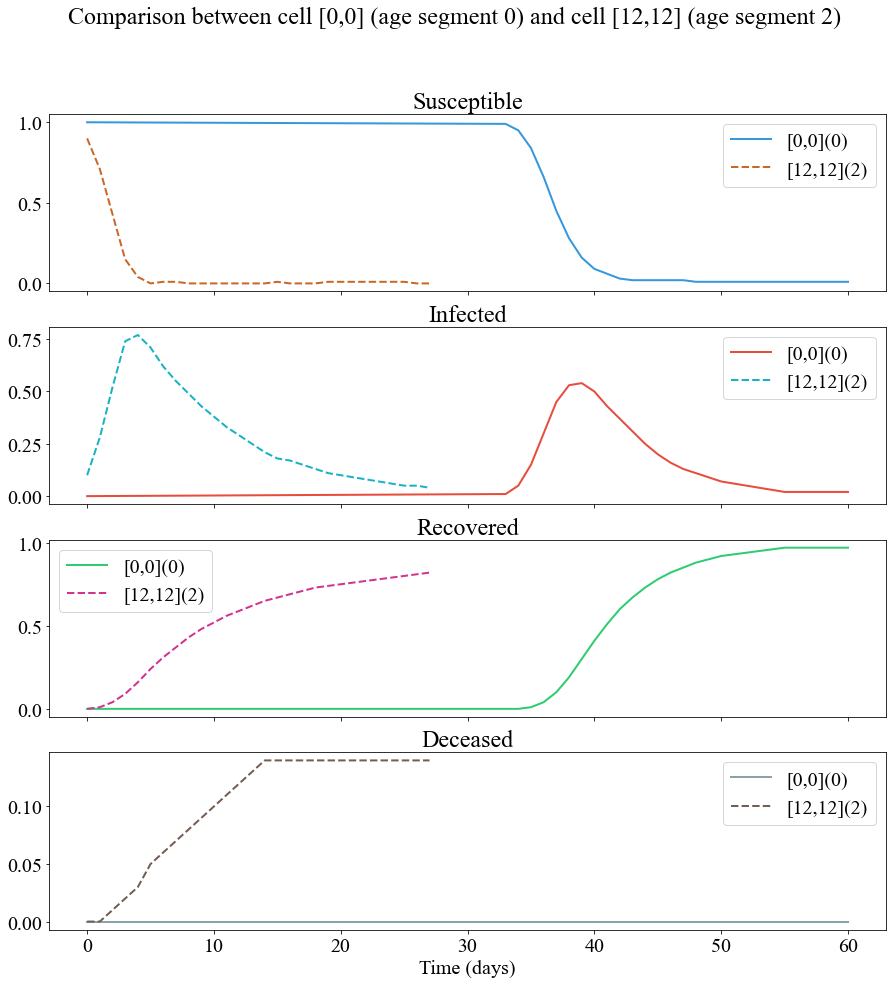

In [104]:
fig, axs = plt.subplots(4, figsize=(15,15), sharex=True)
linewidth = 2
figname = os.path.join(res_folder, "sep_comp_lines_plot")

if target_cell_1 is None:
    cell_name_1 = "scenario"
    df_1 = scenario_df
else:
    cell_name_1 = "[{},{}]".format(target_cell_1[0], target_cell_1[1])
    df_1 = cells_df.loc[(cells_df["x"] == target_cell_1[0]) & (cells_df["y"] == target_cell_1[1])]
    df_1 = df_1.set_index("time")
    
if target_cell_2 is None:
    cell_name_2 = "scenario"
    df_2 = scenario_df
else:
    cell_name_2 = "[{},{}]".format(target_cell_2[0], target_cell_2[1])
    df_2 = cells_df.loc[(cells_df["x"] == target_cell_2[0]) & (cells_df["y"] == target_cell_2[1])]
    df_2 = df_2.set_index("time")


sus_col_1 = "susceptible"
inf_col_1 = "infected"
rec_col_1 = "recovered"
dec_col_1 = "deceased"
age_suffix_1 = None
if age_segment_1 is not None:
    suffix = "_{}".format(age_segment_1)
    sus_col_1 += suffix
    inf_col_1 += suffix
    rec_col_1 += suffix
    dec_col_1 += suffix
    age_suffix_1 = str(age_segment_1)

sus_col_2 = "susceptible"
inf_col_2 = "infected"
rec_col_2 = "recovered"
dec_col_2 = "deceased"

age_suffix_2 = None
if age_segment_2 is not None:
    suffix = "_{}".format(age_segment_2)
    sus_col_2 += suffix
    inf_col_2 += suffix
    rec_col_2 += suffix
    dec_col_2 += suffix
    age_suffix_2 = str(age_segment_2)

cell_1_code = cell_name_1 if age_suffix_1 is None else cell_name_1 + "({})".format(age_suffix_1)
cell_2_code = cell_name_2 if age_suffix_2 is None else cell_name_2 + "({})".format(age_suffix_2)
figname += "_{}_vs_{}.pdf".format(cell_1_code, cell_name_2)

x_1 = list(df_1.index)
x_2 = list(df_2.index)

axs[0].plot(x_1, df_1[sus_col_1], label=cell_1_code, color=COLOR_SUSCEPTIBLE_1, linewidth=linewidth)
axs[0].plot(x_2, df_2[sus_col_2], label=cell_2_code, color=COLOR_SUSCEPTIBLE_2, linewidth=linewidth, linestyle="--")
axs[0].set_title('Susceptible')
axs[0].legend()


axs[1].plot(x_1, df_1[inf_col_1], label=cell_1_code, color=COLOR_INFECTED_1, linewidth=linewidth)
axs[1].plot(x_2, df_2[inf_col_2], label=cell_2_code, color=COLOR_INFECTED_2, linewidth=linewidth, linestyle="--")
axs[1].set_title('Infected')
axs[1].legend()

axs[2].plot(x_1, df_1[rec_col_1], label=cell_1_code, color=COLOR_RECOVERED_1, linewidth=linewidth)
axs[2].plot(x_2, df_2[rec_col_2], label=cell_2_code, color=COLOR_RECOVERED_2, linewidth=linewidth, linestyle="--")
axs[2].set_title('Recovered')
axs[2].legend()


axs[3].plot(x_1, df_1[dec_col_1], label=cell_1_code, color=COLOR_DECEASED_1, linewidth=linewidth)
axs[3].plot(x_2, df_2[dec_col_2], label=cell_2_code, color=COLOR_DECEASED_2, linewidth=linewidth, linestyle="--")
axs[3].set(xlabel='Time (days)')
axs[3].set_title('Deceased')
axs[3].legend()

if target_cell_1 is not None:
    cell_name_1 = "cell " + cell_name_1
if target_cell_2 is not None:
    cell_name_2 = "cell " + cell_name_2
cell_1_code = cell_name_1 + " (all age segments)" if age_segment_1 is None else cell_name_1 + " (age segment {})".format(age_segment_1)
cell_2_code = cell_name_2 + " (all age segments)" if age_segment_2 is None else cell_name_2 + " (age segment {})".format(age_segment_2)
fig.suptitle("Comparison between {} and {}".format(cell_1_code, cell_2_code))
plt.savefig(figname)

We reached the end of this Jupyter notebook. Let's run another simulation so we can visualize the effect 